In [1]:
import wandb
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
def get_results(project:str, entity:str ):
    api = wandb.Api()
    runs = api.runs(f"{entity}/{project}")
    run_max_metrics = []
    for run in runs:
        if run.name[-2:] == "20": 
            # Extract seed and history
            seed = run.config.get("seed", "N/A")
            run_history = run.history()
            rank_metrics = "eval/matthews_correlation"

            # Regex pattern to parse run name
            pattern = r"results_(?P<task>[a-zA-Z0-9]+)_(?P<rank_min>[\d.]+)_(?P<rank_max>[\d.]+)_(?P<alpha_min>[\d.]+)_(?P<alpha_max>[\d.]+)_(?P<seed>\d+)_(?P<lr>[\d.]+)_(?P<rank_avg>[\d.]+)"
            match = re.match(pattern, run.name)

            if match and rank_metrics:
                # Extract components from the run name
                task = match.group("task")
                rank_min = float(match.group("rank_min"))
                rank_max = float(match.group("rank_max"))
                alpha_min = float(match.group("alpha_min"))
                alpha_max = float(match.group("alpha_max"))
                seed = int(match.group("seed"))
                rank_allocation_learning_rate = float(match.group("lr"))
                rank_average = float(match.group("rank_avg"))

                # Get the overall max of the rank metrics
                overall_max = run.history(keys=[rank_metrics])[rank_metrics].max() * 100

                # Append parsed data to run_max_metrics
                run_max_metrics.append({
                    "run_name": run.name,
                    "task": task,
                    "rank_min": rank_min,
                    "rank_max": rank_max,
                    "alpha_min": alpha_min,
                    "alpha_max": alpha_max,
                    "rank_allocation_learning_rate": rank_allocation_learning_rate,
                    "rank_average": rank_average,
                    "seed": seed,
                    "overall_max": overall_max
                })
    return sorted(run_max_metrics, key=lambda x: x["overall_max"], reverse=True)

In [3]:
from IPython.display import Markdown, display

def print_results(run_max_metrics):
    # Create the table header
    table = "| Run Name | Task | Rank Min | Rank Max | Rank Allocation Learning Rate | Rank Average | Alpha Min | Alpha Max | Seed | Overall Max |\n"
    table += "|----------|------|----------|----------|--------------------------------|--------------|-----------|-----------|------|-------------|\n"
    
    # Add rows
    for result in run_max_metrics:
        row = (
            f"| {result['run_name']} "
            f"| {result['task']} "
            f"| {result['rank_min']} "
            f"| {result['rank_max']} "
            f"| {result['rank_allocation_learning_rate']} "
            f"| {result['rank_average']} "
            f"| {result['alpha_min']} "
            f"| {result['alpha_max']} "
            f"| {result['seed']} "
            f"| {result['overall_max']:.2f} |"
        )
        table += row + "\n"
    
    # Render as Markdown
    display(Markdown(table))

In [4]:
def plot_results(run_max_metrics: str):
    run_names = [result['run_name'] for result in run_max_metrics]
    overall_max = [result['overall_max'] for result in run_max_metrics]
    learning_rates = [result['rank_allocation_learning_rate'] for result in run_max_metrics]

    # Define baseline and its error
    baseline_median = 68.08
    baseline_std = 1.21

    # Assign colors based on unique learning rates
    unique_lrs = sorted(set(learning_rates))
    color_map = {lr: plt.cm.tab10(i % 10) for i, lr in enumerate(unique_lrs)}
    colors = [color_map[lr] for lr in learning_rates]

    # Plotting the bar plot
    plt.figure(figsize=(12, 6))
    bar_positions = np.arange(len(run_names))
    plt.bar(bar_positions, overall_max, color=colors, edgecolor='black')

    rank_25_median = 68.55
    rank_25_std = 0.81

    # Add baselines with shading for std
    plt.axhline(baseline_median, color='red', linestyle='--', label='Baseline for r=20')
    plt.axhline(rank_25_median, color='black', linestyle='--', label='Baseline for r=25')

    plt.fill_between(bar_positions, baseline_median - baseline_std, baseline_median + baseline_std, color='red', alpha=0.2, label='Baseline (r=20) ± std')
    plt.fill_between(bar_positions, rank_25_median - rank_25_std, rank_25_median + rank_25_std, color='black', alpha=0.1, label='Baseline (r=25) ± std')

    # Adding labels and legend
    plt.xticks(bar_positions, run_names, rotation=90)
    plt.xlabel('Run Names')
    plt.ylabel('Overall Max')
    plt.title('Overall Max Metrics by Run')

    # Create legend for learning rates
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=f'LR: {lr}', markerfacecolor=color_map[lr], markersize=10) for lr in unique_lrs]
    plt.legend(handles=legend_elements + [plt.Line2D([0], [0], color='red', linestyle='--', label='Baseline for r=20'),
                                           plt.Line2D([0], [0], color='black', linestyle='--', label='Baseline for r=25')],
               loc='upper left', bbox_to_anchor=(1, 1), title="Legend")
    plt.ylim(60, 70)  # Adjust the upper limit if needed

    plt.tight_layout()
    plt.show()



In [6]:
def plot_rank_distribution(project:str, entity:str, run_name:str ):
    api = wandb.Api()
    runs = api.runs(f"{entity}/{project}")
    run = next(run for run in runs if run.name == run_name)
    rank_metrics = "eval/matthews_correlation"
    keys=[rank_metrics, '_step']
    history=run.scan_history(keys=keys, page_size=1000)

    history_df = pd.DataFrame(history)
    max_correlation = history_df[rank_metrics].max()
    max_step = history_df.loc[history_df[rank_metrics].idxmax(), '_step']
    rank_allocation_keys=[f'train/rank_allocation_{i}' for i in range(0, 96)]
    step_data = run.scan_history(keys=['_step'] + rank_allocation_keys, page_size=1000)
    step_data_df = pd.DataFrame(step_data)
    step_values = step_data_df[(step_data_df['_step'] >= max_step - 3)]
    plt.bar(range(96), step_values[rank_allocation_keys].values[0])
    plt.title(f"Max Matthews correlation: {max_correlation} at step: {max_step} for run: {run_name}")
    plt.show()

In [7]:
def display_project_stats(project:str, entity:str ):
   run_max_metrics=get_results(project=project, entity=entity)
   print_results(run_max_metrics)
   plot_results(run_max_metrics)
   best_run = max(run_max_metrics, key=lambda x: x["overall_max"])
   plot_rank_distribution(project=project, entity=entity, run_name=best_run['run_name'])

### Uniform initialization (r=20 for every parameter matrix), grid search over learning rates and rank ranges

| Run Name | Task | Rank Min | Rank Max | Rank Allocation Learning Rate | Rank Average | Alpha Min | Alpha Max | Seed | Overall Max |
|----------|------|----------|----------|--------------------------------|--------------|-----------|-----------|------|-------------|
| results_cola_15_25_0.5_3_3_0.01_20 | cola | 15.0 | 25.0 | 0.01 | 20.0 | 0.5 | 3.0 | 3 | 69.90 |
| results_cola_15_25_0.5_3_3_0.002_20 | cola | 15.0 | 25.0 | 0.002 | 20.0 | 0.5 | 3.0 | 3 | 68.70 |
| results_cola_5_25_0.5_3_3_0.02_20 | cola | 5.0 | 25.0 | 0.02 | 20.0 | 0.5 | 3.0 | 3 | 68.59 |
| results_cola_5_35_0.5_3_3_0.02_20 | cola | 5.0 | 35.0 | 0.02 | 20.0 | 0.5 | 3.0 | 3 | 68.40 |
| results_cola_15_35_0.5_3_3_0.01_20 | cola | 15.0 | 35.0 | 0.01 | 20.0 | 0.5 | 3.0 | 3 | 68.38 |
| results_cola_5_50_0.5_3_3_0.05_20 | cola | 5.0 | 50.0 | 0.05 | 20.0 | 0.5 | 3.0 | 3 | 68.12 |
| results_cola_15_25_0.5_3_3_0.005_20 | cola | 15.0 | 25.0 | 0.005 | 20.0 | 0.5 | 3.0 | 3 | 68.08 |
| results_cola_15_35_0.5_3_3_0.005_20 | cola | 15.0 | 35.0 | 0.005 | 20.0 | 0.5 | 3.0 | 3 | 67.91 |
| results_cola_15_50_0.5_3_3_0.002_20 | cola | 15.0 | 50.0 | 0.002 | 20.0 | 0.5 | 3.0 | 3 | 67.82 |
| results_cola_15_50_0.5_3_3_0.01_20 | cola | 15.0 | 50.0 | 0.01 | 20.0 | 0.5 | 3.0 | 3 | 67.78 |
| results_cola_15_50_0.5_3_3_0.005_20 | cola | 15.0 | 50.0 | 0.005 | 20.0 | 0.5 | 3.0 | 3 | 67.74 |
| results_cola_15_35_0.5_3_3_0.002_20 | cola | 15.0 | 35.0 | 0.002 | 20.0 | 0.5 | 3.0 | 3 | 67.57 |
| results_cola_5_35_0.5_3_3_0.1_20 | cola | 5.0 | 35.0 | 0.1 | 20.0 | 0.5 | 3.0 | 3 | 67.32 |
| results_cola_5_35_0.5_3_3_0.05_20 | cola | 5.0 | 35.0 | 0.05 | 20.0 | 0.5 | 3.0 | 3 | 67.18 |
| results_cola_5_50_0.5_3_3_0.02_20 | cola | 5.0 | 50.0 | 0.02 | 20.0 | 0.5 | 3.0 | 3 | 66.98 |
| results_cola_5_25_0.5_3_3_0.05_20 | cola | 5.0 | 25.0 | 0.05 | 20.0 | 0.5 | 3.0 | 3 | 66.32 |
| results_cola_5_50_0.5_3_3_0.1_20 | cola | 5.0 | 50.0 | 0.1 | 20.0 | 0.5 | 3.0 | 3 | 66.13 |
| results_cola_5_25_0.5_3_3_0.1_20 | cola | 5.0 | 25.0 | 0.1 | 20.0 | 0.5 | 3.0 | 3 | 66.07 |


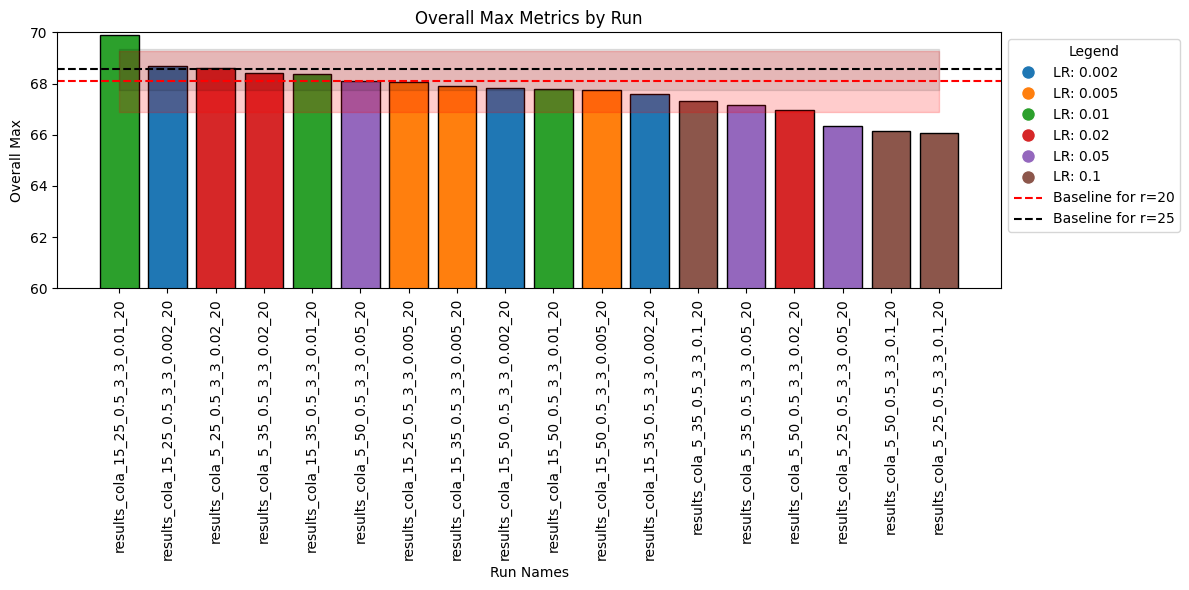

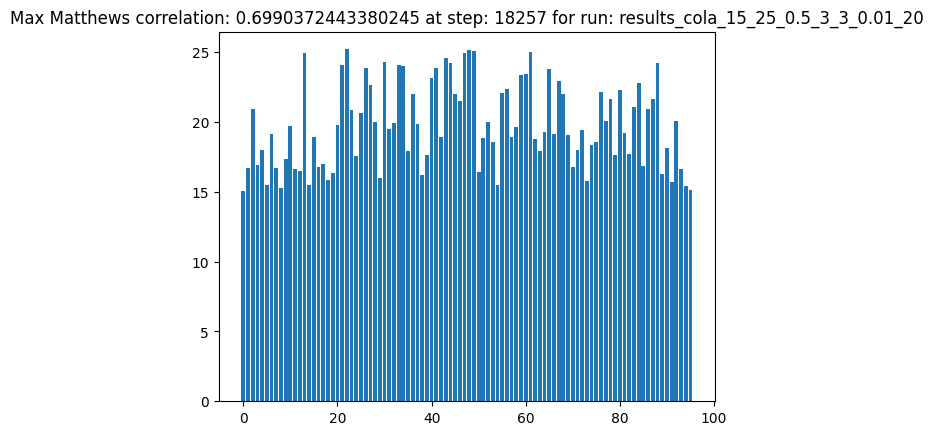

In [8]:
project="adaptive_rank_allocation"
entity="mallahova"
display_project_stats(project=project, entity=entity)

### Uniform initialization

| Run Name | Task | Rank Min | Rank Max | Rank Allocation Learning Rate | Rank Average | Alpha Min | Alpha Max | Seed | Overall Max |
|----------|------|----------|----------|--------------------------------|--------------|-----------|-----------|------|-------------|
| results_cola_5_25_0.5_3_5_0.01_20 | cola | 5.0 | 25.0 | 0.01 | 20.0 | 0.5 | 3.0 | 5 | 69.30 |
| results_cola_5_25_0.5_3_9_0.02_20 | cola | 5.0 | 25.0 | 0.02 | 20.0 | 0.5 | 3.0 | 9 | 68.30 |
| results_cola_5_25_0.5_3_9_0.01_20 | cola | 5.0 | 25.0 | 0.01 | 20.0 | 0.5 | 3.0 | 9 | 68.05 |
| results_cola_5_25_0.5_3_5_0.02_20 | cola | 5.0 | 25.0 | 0.02 | 20.0 | 0.5 | 3.0 | 5 | 68.01 |
| results_cola_5_25_0.5_3_4_0.02_20 | cola | 5.0 | 25.0 | 0.02 | 20.0 | 0.5 | 3.0 | 4 | 68.00 |
| results_cola_5_25_0.5_3_5_0.002_20 | cola | 5.0 | 25.0 | 0.002 | 20.0 | 0.5 | 3.0 | 5 | 67.74 |
| results_cola_5_25_0.5_3_6_0.002_20 | cola | 5.0 | 25.0 | 0.002 | 20.0 | 0.5 | 3.0 | 6 | 67.70 |
| results_cola_5_25_0.5_3_8_0.02_20 | cola | 5.0 | 25.0 | 0.02 | 20.0 | 0.5 | 3.0 | 8 | 67.50 |
| results_cola_5_25_0.5_3_9_0.002_20 | cola | 5.0 | 25.0 | 0.002 | 20.0 | 0.5 | 3.0 | 9 | 67.34 |
| results_cola_5_25_0.5_3_8_0.002_20 | cola | 5.0 | 25.0 | 0.002 | 20.0 | 0.5 | 3.0 | 8 | 67.26 |
| results_cola_5_25_0.5_3_4_0.002_20 | cola | 5.0 | 25.0 | 0.002 | 20.0 | 0.5 | 3.0 | 4 | 67.16 |
| results_cola_5_25_0.5_3_8_0.01_20 | cola | 5.0 | 25.0 | 0.01 | 20.0 | 0.5 | 3.0 | 8 | 67.10 |
| results_cola_5_25_0.5_3_7_0.01_20 | cola | 5.0 | 25.0 | 0.01 | 20.0 | 0.5 | 3.0 | 7 | 67.00 |
| results_cola_5_25_0.5_3_7_0.002_20 | cola | 5.0 | 25.0 | 0.002 | 20.0 | 0.5 | 3.0 | 7 | 66.75 |
| results_cola_5_25_0.5_3_6_0.01_20 | cola | 5.0 | 25.0 | 0.01 | 20.0 | 0.5 | 3.0 | 6 | 66.74 |
| results_cola_5_25_0.5_3_4_0.01_20 | cola | 5.0 | 25.0 | 0.01 | 20.0 | 0.5 | 3.0 | 4 | 66.57 |
| results_cola_5_25_0.5_3_7_0.02_20 | cola | 5.0 | 25.0 | 0.02 | 20.0 | 0.5 | 3.0 | 7 | 65.98 |
| results_cola_5_25_0.5_3_6_0.02_20 | cola | 5.0 | 25.0 | 0.02 | 20.0 | 0.5 | 3.0 | 6 | 63.60 |


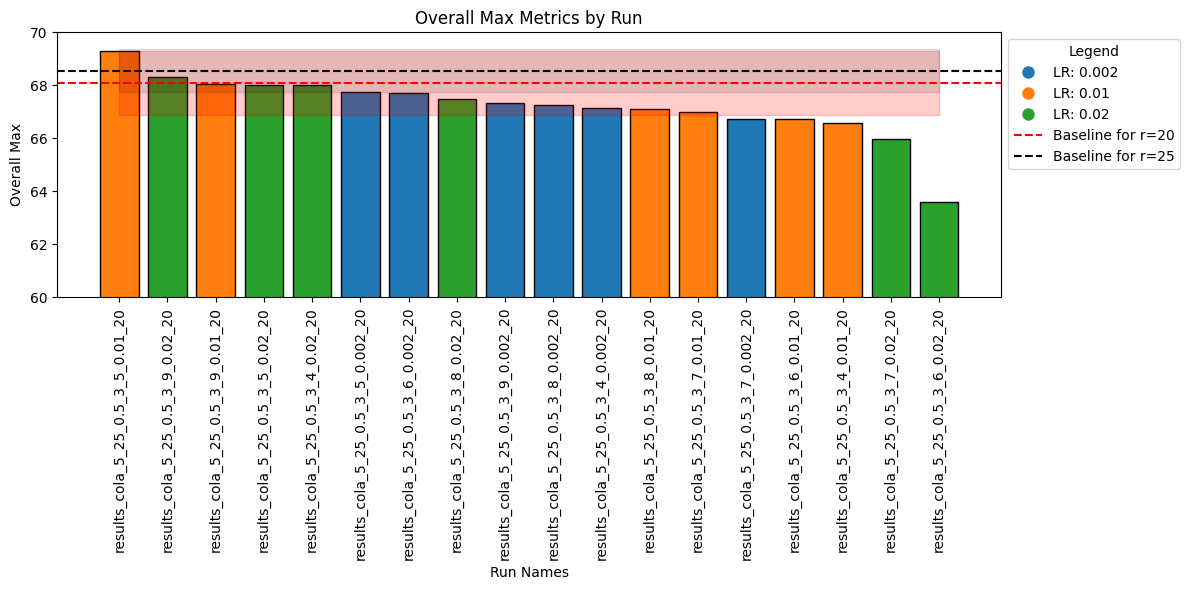

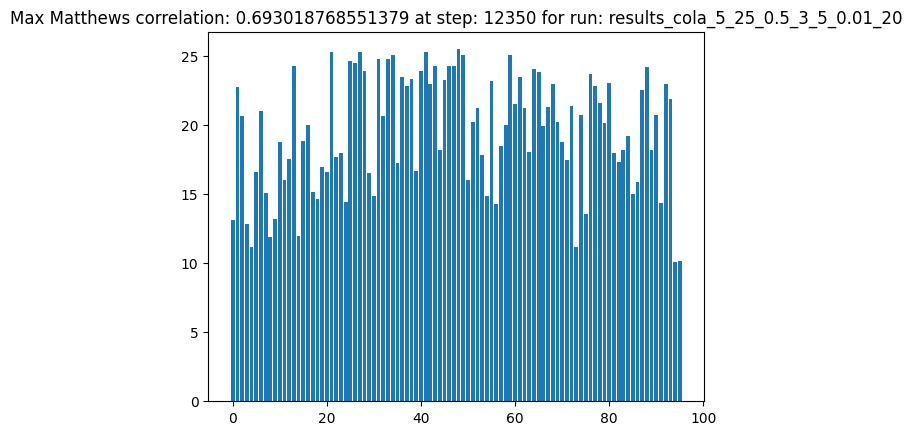

In [9]:
project = "adaptive_rank_allocation_l_r"
entity = "mallahova"
display_project_stats(project=project, entity=entity)

### Randn initialization

| Run Name | Task | Rank Min | Rank Max | Rank Allocation Learning Rate | Rank Average | Alpha Min | Alpha Max | Seed | Overall Max |
|----------|------|----------|----------|--------------------------------|--------------|-----------|-----------|------|-------------|
| results_cola_5_25_0.5_3_0_0.002_20 | cola | 5.0 | 25.0 | 0.002 | 20.0 | 0.5 | 3.0 | 0 | 69.62 |
| results_cola_5_25_0.5_3_3_0.01_20 | cola | 5.0 | 25.0 | 0.01 | 20.0 | 0.5 | 3.0 | 3 | 68.90 |
| results_cola_5_25_0.5_3_1_0.01_20 | cola | 5.0 | 25.0 | 0.01 | 20.0 | 0.5 | 3.0 | 1 | 68.72 |
| results_cola_5_25_0.5_3_4_0.002_20 | cola | 5.0 | 25.0 | 0.002 | 20.0 | 0.5 | 3.0 | 4 | 68.64 |
| results_cola_5_25_0.5_3_3_0.002_20 | cola | 5.0 | 25.0 | 0.002 | 20.0 | 0.5 | 3.0 | 3 | 68.22 |
| results_cola_5_25_0.5_3_2_0.02_20 | cola | 5.0 | 25.0 | 0.02 | 20.0 | 0.5 | 3.0 | 2 | 68.03 |
| results_cola_5_25_0.5_3_3_0.02_20 | cola | 5.0 | 25.0 | 0.02 | 20.0 | 0.5 | 3.0 | 3 | 67.87 |
| results_cola_5_25_0.5_3_0_0.01_20 | cola | 5.0 | 25.0 | 0.01 | 20.0 | 0.5 | 3.0 | 0 | 67.60 |
| results_cola_5_25_0.5_3_0_0.02_20 | cola | 5.0 | 25.0 | 0.02 | 20.0 | 0.5 | 3.0 | 0 | 67.48 |
| results_cola_5_25_0.5_3_2_0.01_20 | cola | 5.0 | 25.0 | 0.01 | 20.0 | 0.5 | 3.0 | 2 | 67.45 |
| results_cola_5_25_0.5_3_4_0.02_20 | cola | 5.0 | 25.0 | 0.02 | 20.0 | 0.5 | 3.0 | 4 | 67.34 |
| results_cola_5_25_0.5_3_2_0.002_20 | cola | 5.0 | 25.0 | 0.002 | 20.0 | 0.5 | 3.0 | 2 | 67.19 |
| results_cola_5_25_0.5_3_1_0.002_20 | cola | 5.0 | 25.0 | 0.002 | 20.0 | 0.5 | 3.0 | 1 | 67.12 |
| results_cola_5_25_0.5_3_4_0.01_20 | cola | 5.0 | 25.0 | 0.01 | 20.0 | 0.5 | 3.0 | 4 | 66.64 |
| results_cola_5_25_0.5_3_1_0.02_20 | cola | 5.0 | 25.0 | 0.02 | 20.0 | 0.5 | 3.0 | 1 | 65.88 |


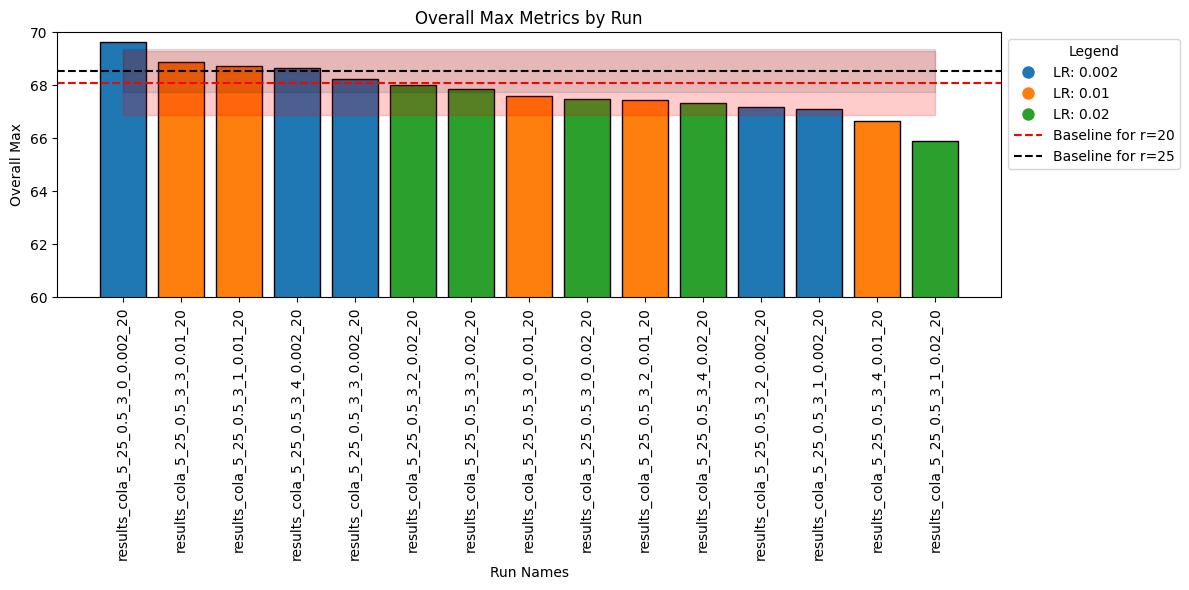

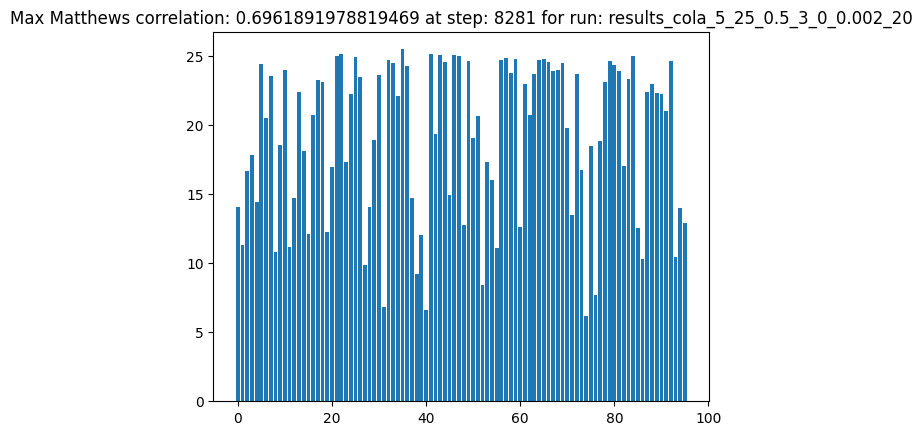

In [10]:
project = "adaptive_rank_allocation_random_init"
entity = "mallahova"
display_project_stats(project=project, entity=entity)

### Quadratic initialization

| Run Name | Task | Rank Min | Rank Max | Rank Allocation Learning Rate | Rank Average | Alpha Min | Alpha Max | Seed | Overall Max |
|----------|------|----------|----------|--------------------------------|--------------|-----------|-----------|------|-------------|
| results_cola_5_25_0.5_3_3_0.01_20 | cola | 5.0 | 25.0 | 0.01 | 20.0 | 0.5 | 3.0 | 3 | 69.53 |
| results_cola_5_25_0.5_3_1_0.002_20 | cola | 5.0 | 25.0 | 0.002 | 20.0 | 0.5 | 3.0 | 1 | 68.54 |
| results_cola_5_25_0.5_3_4_0.002_20 | cola | 5.0 | 25.0 | 0.002 | 20.0 | 0.5 | 3.0 | 4 | 68.52 |
| results_cola_5_25_0.5_3_2_0.02_20 | cola | 5.0 | 25.0 | 0.02 | 20.0 | 0.5 | 3.0 | 2 | 68.14 |
| results_cola_5_25_0.5_3_1_0.02_20 | cola | 5.0 | 25.0 | 0.02 | 20.0 | 0.5 | 3.0 | 1 | 68.14 |
| results_cola_5_25_0.5_3_3_0.02_20 | cola | 5.0 | 25.0 | 0.02 | 20.0 | 0.5 | 3.0 | 3 | 68.13 |
| results_cola_5_25_0.5_3_4_0.01_20 | cola | 5.0 | 25.0 | 0.01 | 20.0 | 0.5 | 3.0 | 4 | 68.03 |
| results_cola_5_25_0.5_3_0_0.002_20 | cola | 5.0 | 25.0 | 0.002 | 20.0 | 0.5 | 3.0 | 0 | 67.92 |
| results_cola_5_25_0.5_3_2_0.002_20 | cola | 5.0 | 25.0 | 0.002 | 20.0 | 0.5 | 3.0 | 2 | 67.71 |
| results_cola_5_25_0.5_3_3_0.002_20 | cola | 5.0 | 25.0 | 0.002 | 20.0 | 0.5 | 3.0 | 3 | 67.54 |
| results_cola_5_25_0.5_3_1_0.01_20 | cola | 5.0 | 25.0 | 0.01 | 20.0 | 0.5 | 3.0 | 1 | 67.10 |
| results_cola_5_25_0.5_3_0_0.02_20 | cola | 5.0 | 25.0 | 0.02 | 20.0 | 0.5 | 3.0 | 0 | 66.93 |
| results_cola_5_25_0.5_3_4_0.02_20 | cola | 5.0 | 25.0 | 0.02 | 20.0 | 0.5 | 3.0 | 4 | 66.37 |
| results_cola_5_25_0.5_3_0_0.01_20 | cola | 5.0 | 25.0 | 0.01 | 20.0 | 0.5 | 3.0 | 0 | 66.29 |
| results_cola_5_25_0.5_3_2_0.01_20 | cola | 5.0 | 25.0 | 0.01 | 20.0 | 0.5 | 3.0 | 2 | 65.88 |


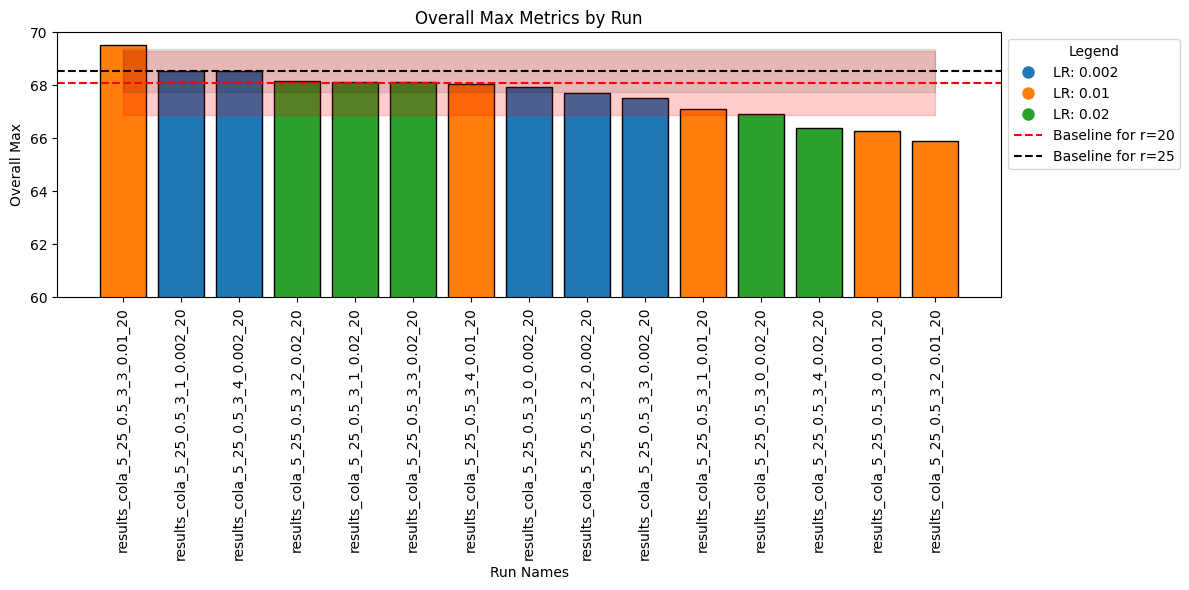

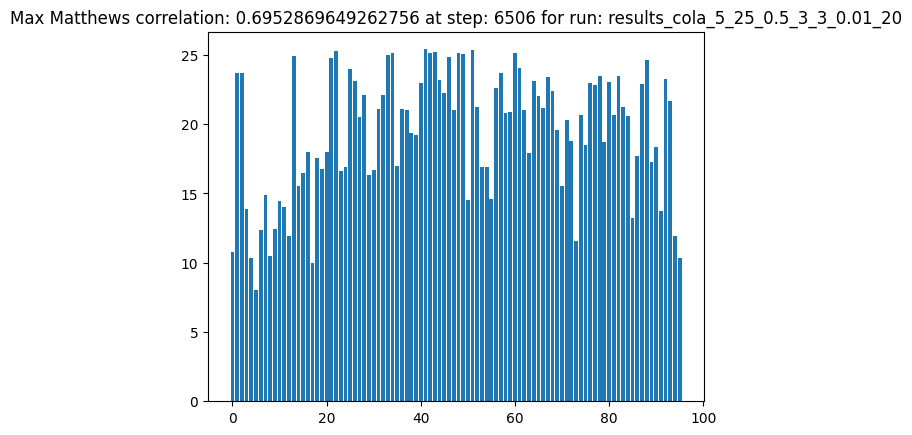

In [11]:
project = "adaptive_rank_allocation_quadratic_init"
entity = "mallahova" 
display_project_stats(project=project, entity=entity)

### Left skewed (centered at 3/4*n) initialization

| Run Name | Task | Rank Min | Rank Max | Rank Allocation Learning Rate | Rank Average | Alpha Min | Alpha Max | Seed | Overall Max |
|----------|------|----------|----------|--------------------------------|--------------|-----------|-----------|------|-------------|
| results_cola_5_25_0.5_3_2_0.005_20 | cola | 5.0 | 25.0 | 0.005 | 20.0 | 0.5 | 3.0 | 2 | 69.09 |
| results_cola_5_25_0.5_3_3_0.002_20 | cola | 5.0 | 25.0 | 0.002 | 20.0 | 0.5 | 3.0 | 3 | 68.50 |
| results_cola_5_25_0.5_3_2_0.001_20 | cola | 5.0 | 25.0 | 0.001 | 20.0 | 0.5 | 3.0 | 2 | 68.40 |
| results_cola_5_25_0.5_3_4_0.005_20 | cola | 5.0 | 25.0 | 0.005 | 20.0 | 0.5 | 3.0 | 4 | 67.90 |
| results_cola_5_25_0.5_3_1_0.01_20 | cola | 5.0 | 25.0 | 0.01 | 20.0 | 0.5 | 3.0 | 1 | 67.71 |
| results_cola_5_25_0.5_3_5_0.005_20 | cola | 5.0 | 25.0 | 0.005 | 20.0 | 0.5 | 3.0 | 5 | 67.66 |
| results_cola_5_25_0.5_3_1_0.002_20 | cola | 5.0 | 25.0 | 0.002 | 20.0 | 0.5 | 3.0 | 1 | 67.37 |
| results_cola_5_25_0.5_3_5_0.001_20 | cola | 5.0 | 25.0 | 0.001 | 20.0 | 0.5 | 3.0 | 5 | 67.32 |
| results_cola_5_25_0.5_3_1_0.02_20 | cola | 5.0 | 25.0 | 0.02 | 20.0 | 0.5 | 3.0 | 1 | 67.20 |
| results_cola_5_25_0.5_3_4_0.002_20 | cola | 5.0 | 25.0 | 0.002 | 20.0 | 0.5 | 3.0 | 4 | 67.14 |
| results_cola_5_25_0.5_3_2_0.002_20 | cola | 5.0 | 25.0 | 0.002 | 20.0 | 0.5 | 3.0 | 2 | 66.99 |
| results_cola_5_25_0.5_3_4_0.001_20 | cola | 5.0 | 25.0 | 0.001 | 20.0 | 0.5 | 3.0 | 4 | 66.99 |
| results_cola_5_25_0.5_3_3_0.005_20 | cola | 5.0 | 25.0 | 0.005 | 20.0 | 0.5 | 3.0 | 3 | 66.16 |
| results_cola_5_25_0.5_3_3_0.001_20 | cola | 5.0 | 25.0 | 0.001 | 20.0 | 0.5 | 3.0 | 3 | 65.99 |
| results_cola_5_25_0.5_3_5_0.002_20 | cola | 5.0 | 25.0 | 0.002 | 20.0 | 0.5 | 3.0 | 5 | 65.92 |


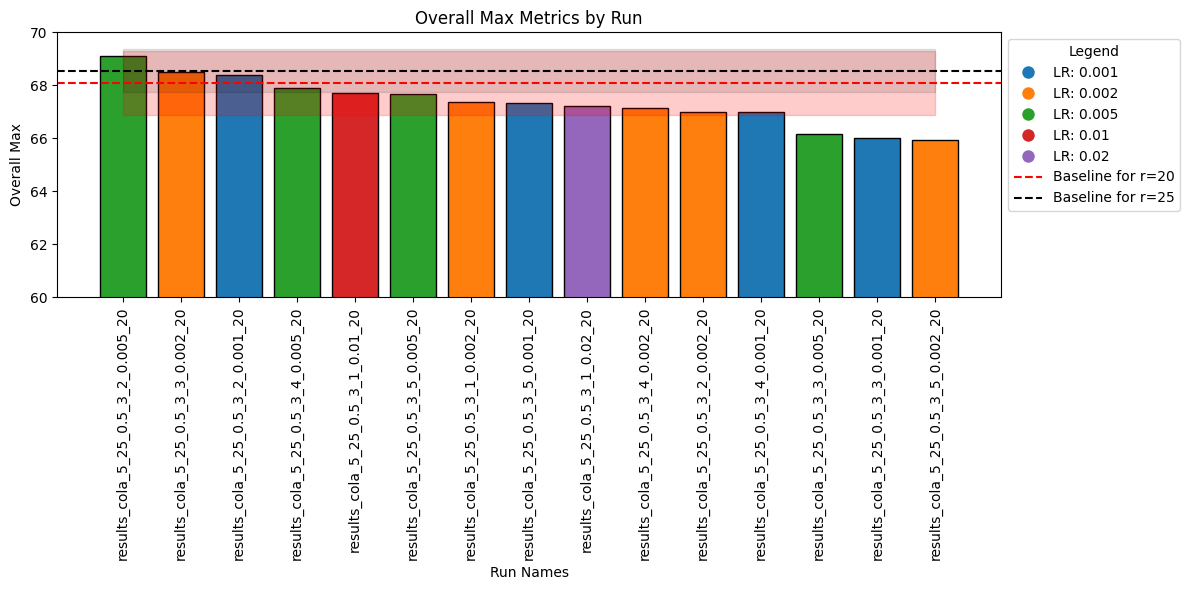

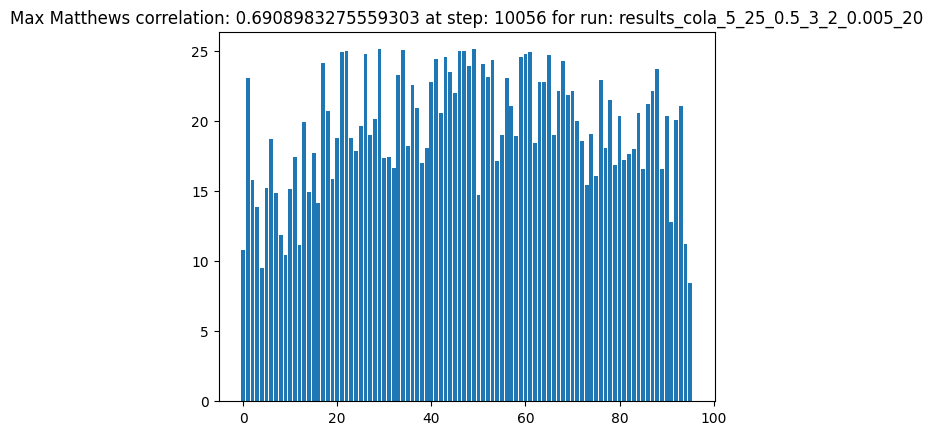

In [12]:
project = "adaptive_rank_allocation_left_skewed_init"
entity = "mallahova"
display_project_stats(project=project, entity=entity)

### Uniform, randn, quadratic, left-skewed plotted together
Randn initialization has the best results, 4 of which outmach the baseline for r=25.

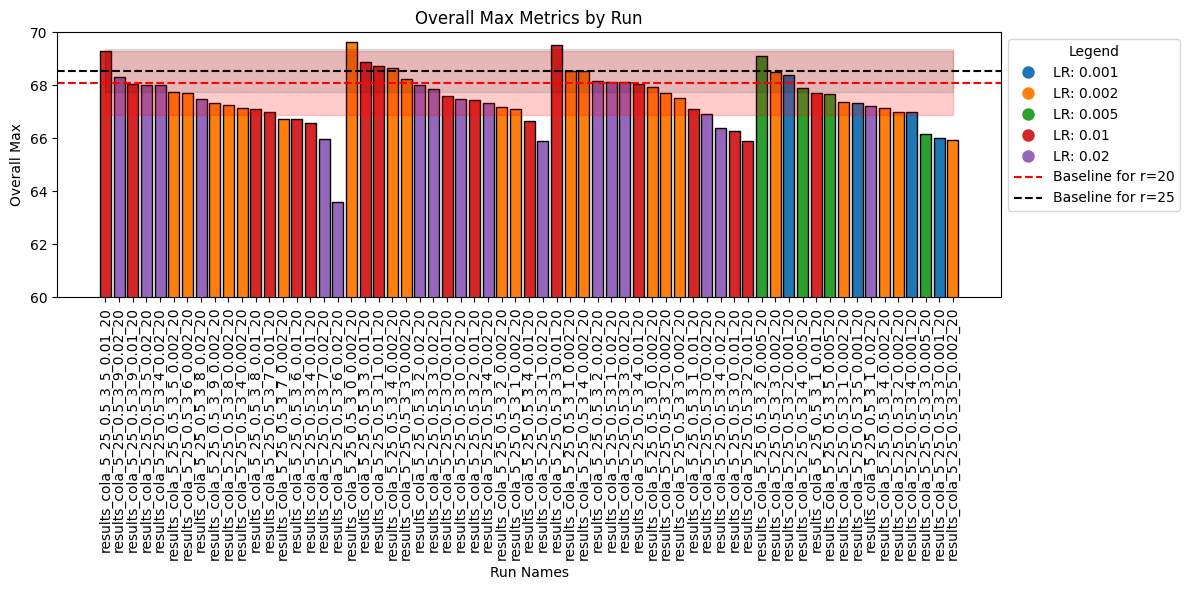

['adaptive_rank_allocation_l_r', 'adaptive_rank_allocation_random_init', 'adaptive_rank_allocation_quadratic_init', 'adaptive_rank_allocation_left_skewed_init']


In [14]:
projects=[ "adaptive_rank_allocation_l_r",  "adaptive_rank_allocation_random_init", "adaptive_rank_allocation_quadratic_init", "adaptive_rank_allocation_left_skewed_init"]
run_max_metrics=[]
for project in projects:
   run_max_metrics.extend(get_results(project=project, entity=entity))
plot_results(run_max_metrics)
print(projects)

### Observations
At the beginning of the training (first 2 epochs), the ranks for first 33% of the layers are getting lower, while the ranks for 33% tend to get higher.

 <img src="assets/rank_allocation_beginning.png" alt=“LoRA-XS” width=90%>

### References
The visualization of each of the initializations is located at algorithm_visualization.ipynb